In [1]:
import yfinance as yf
import time
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns

In [2]:
tick = ['ZEC-USD']
start_date = datetime(2023, 10, 1).strftime('%Y-%m-%d')
end_date = datetime(2024, 10, 1).strftime('%Y-%m-%d')

In [3]:
df = yf.download(tick, start= start_date , end = end_date )[['Close']]

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True


In [4]:
df

Price,Close
Ticker,ZEC-USD
Date,
2023-10-01,28.063318
2023-10-02,27.304394
2023-10-03,26.915659
2023-10-04,27.146259
2023-10-05,27.155380
...,...
2024-09-26,30.190125
2024-09-27,30.426661


lets apply ARIMA

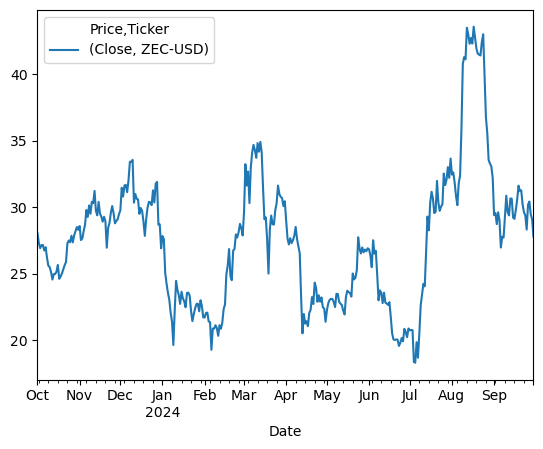

In [5]:
#first visualise data 
df.plot()
plt.show()

In [6]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [7]:
result = adfuller(df['Close'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.8273219892188695
p-value: 0.05447575619196578


In [8]:
# Step 1: Differencing the data to make it stationary
df['Close_diff'] = df['Close'].diff().dropna()

# Step 2: Perform the ADF test again on the differenced data
result_diff = adfuller(df['Close_diff'].dropna())
print(f'ADF Statistic (Differenced): {result_diff[0]}')
print(f'p-value (Differenced): {result_diff[1]}')

ADF Statistic (Differenced): -18.031755656025435
p-value (Differenced): 2.6749231847850815e-30


In [9]:
df.isnull().sum()

Price       Ticker 
Close       ZEC-USD    0
Close_diff             1
dtype: int64

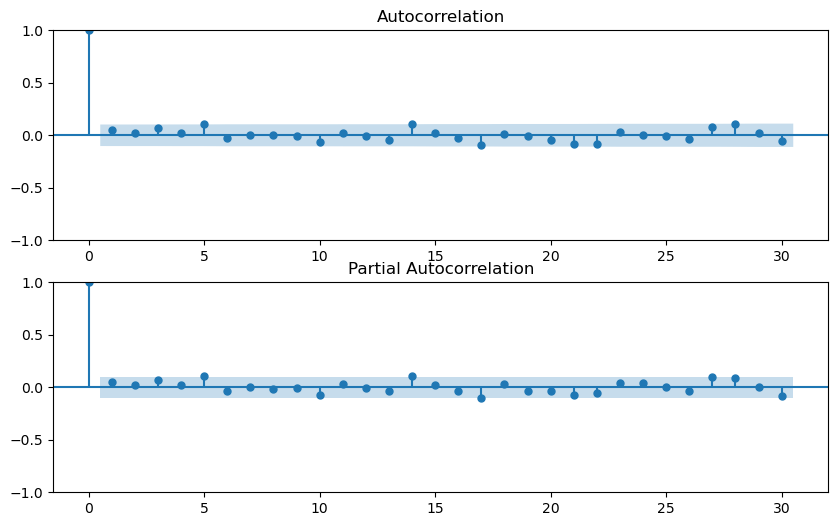

In [10]:
plt.figure(figsize=(10, 6))

plt.subplot(211)
plot_acf(df['Close_diff'].dropna(), lags=30, ax=plt.gca())

plt.subplot(212)
plot_pacf(df['Close_diff'].dropna(), lags=30, ax=plt.gca())

plt.show()

In [11]:
from statsmodels.tsa.arima.model import ARIMA

# Step 5: Fit ARIMA model (p=1, d=1, q=1)
model = ARIMA(df['Close'], order=(1, 1, 1))
model_fit = model.fit()

# Step 6: Check the summary of the fitted model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                ZEC-USD   No. Observations:                  366
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -556.028
Date:                Sat, 12 Apr 2025   AIC                           1118.057
Time:                        12:47:05   BIC                           1129.756
Sample:                    10-01-2023   HQIC                          1122.706
                         - 09-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7866      0.230      3.416      0.001       0.335       1.238
ma.L1         -0.7322      0.251     -2.923      0.003      -1.223      -0.241
sigma2         1.2322      0.069     17.898      0.0

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


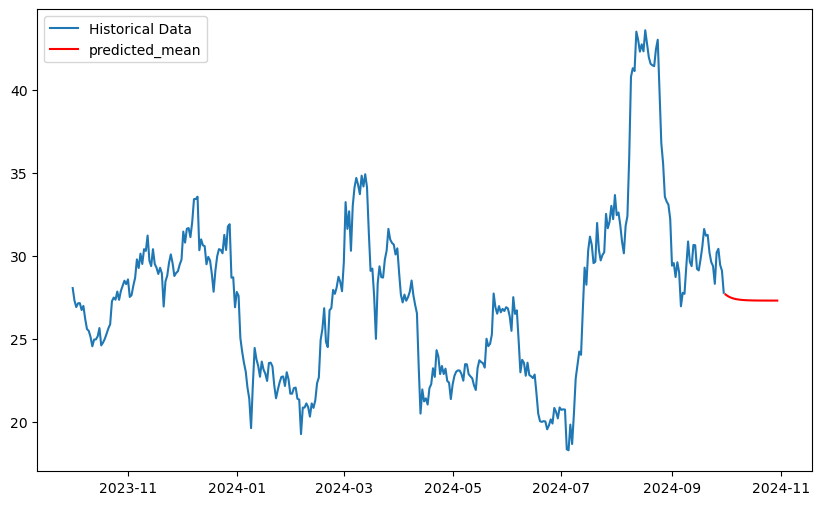

In [24]:
# Forecast the next 30 days (for November 2024)
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

# Create a DataFrame for the forecasted values
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_df = pd.DataFrame(forecast, index=forecast_index)

# Step 7: Plot the forecast alongside the original data
plt.figure(figsize=(10, 6))
plt.plot(df['Close'], label='Historical Data')
plt.plot(forecast_df, label='predicted_mean', color='red')
plt.legend()
plt.show()
